In [0]:
# selecting tensorflow 2
%tensorflow_version 2.x

In [3]:
# installing dependencies
! pip install simpleitk tensorflow-addons~=0.7 tsalib

     |████████████████████████████████| 42.5MB 74kB/s 


In [0]:
import os
import glob
from pathlib import Path

# changing working directory
os.chdir("/content/drive/My Drive/6th Sem Project/model_server")

In [0]:
from model_server.models import NvNet
from model_server.utils import Checkpoint
from model_server.utils import losses as L
from model_server.utils import metrics as M
from model_server.utils.dataset import get_files, load_nii, preprocess_data, preprocess_label, resize
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.transform

In [0]:
input_shape = (4, 80, 96, 64)
output_channels = 3
batch_size = 1

In [0]:
def get_dummy_files(use_default = False):
  if not use_default:
    dir = np.random.choice(glob.glob("data/*GG/*"))
  else:
    dir = "data/HGG/Brats18_2013_26_1/"
  return get_files(dir.encode("ascii"))

def _label_load_and_preprocess(path):
  label = load_nii(path)
  return preprocess_label(label[0], out_shape=(80, 96, 64))

def load_and_preprocess(paths):
  inp = load_nii(paths)
  return np.expand_dims(preprocess_data(inp, out_shape=(80, 96, 64)), axis=0)

def get_results(inp, data_for_seg):
  decoder_out, vae_out, z_mean, z_var = nvnet(inp, training=False)

  red_multiplier = [1, 0.2, 0.2]
  green_multiplier = [0.35,0.75,0.25]
  yellow_multiplier = [1,1,0.25]

  seg_in = skimage.color.gray2rgb(data_for_seg)
  seg_in = seg_in / seg_in.max()

  out = overlay(seg_in, decoder_out[0][0], red_multiplier, threshold = 0.8)
  out = overlay(out, decoder_out[0][1], yellow_multiplier, threshold = 0.8)
  return overlay(out, decoder_out[0][2], green_multiplier, threshold = 0.8), (decoder_out, vae_out, z_mean, z_var)

def display_metrics(inp, label, decoder_out, vae_out, z_mean, z_var):
  vae_loss_fn = L.loss_VAE(input_shape=input_shape)
  decoder_loss_fn = L.dice_loss()
  acc_fn = M.dice_coefficient

  decoder_loss = decoder_loss_fn(label, decoder_out)
  vae_loss = vae_loss_fn(inp, vae_out, z_mean, z_var)
  decoder_acc = acc_fn(label, decoder_out)
  vae_acc = acc_fn(inp, vae_out)
  print(f"decoder loss: {decoder_loss}\nvae loss: {vae_loss}\ndecoder accuracy: {decoder_acc}\nvae accuracy: {vae_acc}")

def prepare_data_for_overlay(path: str, out_shape: tuple = (80, 96, 64)):
  data = load_nii([path])[0]
  return skimage.transform.resize(data, output_shape=out_shape)

def overlay(image, mask, multiplier, threshold: int = 1):
  indices = np.argwhere(mask >= threshold)
  out = np.copy(image)
  for i in range(len(indices)):
    out[indices[i][0], indices[i][1], indices[i][2]] = multiplier
  return out

In [9]:
nvnet = NvNet(input_shape=input_shape)
nvnet.load_weights("saved_models/1/")

In [0]:
data_files, _seg_file = get_dummy_files()
data_files.sort()
data_seg = prepare_data_for_overlay(data_files[0])
inp = load_and_preprocess(data_files)
label = _label_load_and_preprocess(_seg_file)

In [0]:
out, (decoder_out, vae_out, z_mean, z_var) = get_results(inp, data_seg)

In [18]:
display_metrics(inp, label, decoder_out, vae_out, z_mean, z_var)

decoder loss: -0.6154646873474121
vae loss: 0.0184186901897192
decoder accuracy: 0.6154646873474121
vae accuracy: 0.9135406017303467


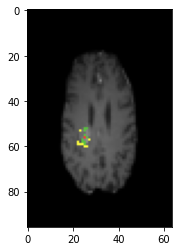

In [14]:
plt.imshow(out[50])